# Advanced Machine Learning - programming assignment 3

*Due: Friday January 14*

*Grading: 10 points total*

**Please fill in:**
* Simon van de Fliert (5708656)
* Dirk Keller (4282264)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import networkx as nx #! pip install networkx
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

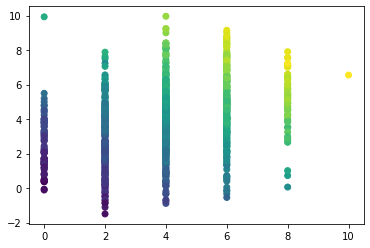

In [2]:
plt.scatter(x, y, c=z)
plt.show()

**Task (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

In [3]:
#convert 1D array to 2D array
reshaped_x = np.array(x).reshape((-1,1))
#create and fit the model
model = linear_model.LinearRegression().fit(reshaped_x, y)
#applying np.linspace
neatly_ordered_x_values = np.linspace(0, 10, num=200).reshape((-1,1))
#predict curve for use in plots
y_values_curve = model.predict(neatly_ordered_x_values)
#predict the y values given the x values for use in RMSE
predicted_observational_y_values = model.predict(reshaped_x)

Text(0, 0.5, 'Outcome')

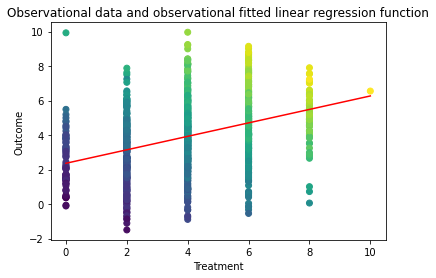

In [20]:
#plot the initial observational data
plt.scatter(x, y, c=z)

#plot the regression curve on top of the observational scatter plot
plt.plot(neatly_ordered_x_values, y_values_curve, 'r')
plt.title('Observational data and observational fitted linear regression function')
plt.xlabel('Treatment')
plt.ylabel('Outcome')

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

## Answer Q1

**Q1. Part 1.** From Glymour and colleagues (2016) we know that a variable $A$ is a direct cause of variable $B$, if variable $A$ appears in the function that assigns the value of variable $B$. Given the code above, we see that the variable $z$ is a direct cause to both variable $x$ and $y$, whilst variable $x$ is a direct cause to $y$. The latter variable, variable $y$, is not the direct cause of any of the previous mentioned variables.

From the code we see that $z$ is not affected by $x$ nor $y$, but $x$ is positively impcated by $z$, and $y$ is positively impacted by $z$ but negatively impacted by $x$. Therefore, the larger the value of $z$, the larger the value of $x$ and $y$. Furthermore, the larger value of $z$ results in a larger value of $x$, and the larger the value of $x$ the lower the value of $y$. However, as we see in the code, $z$ affects $y$ twice as much as $x$.  

**Q1. Part 2.** Assuming that the variable representation is as follows {$x$: treatment, $y$: outcome, $z$: genetic information}, we can see the real world implication of the code above. We see that the treatment and outcome of said treatment are both positively affected by the genetic information of the person. Furthermore, we see that the genetic information of an individual has significant impact on the outcome of the individual, whilst the treatment will have a negative impact on said outcome. From this we can say that the genetic information can determine whether certain treatment is effective. 

For example, in the context of malignant tumour treatment, some people have a genetic disposition (e.g. affects metabolism enzymes that reduces the efficiency of the drug) that is **known** to interfere with the treatment (e.g. chemotherapy), thus higher doses of the drug are administered. At the same time this genetic disposition is actually beneficial for the recovery rate of the patient (the enzymes also break down nutrition for the tumour cell). In addition, higher doses of the treatment (high doses of chemottherapy is actually harmful) reduces the patients recovery chance (or score).

We also know that the treatment is not influenced by the outcome, therefore the variable $y$ is not seen in the function of $x$. However, we might need to alter the treatment strength based on the genetic information, which is why we see that the variable $z$ is seen in the function of variable $x$. Variable $z$ follows the same logic, as the treatment and outcome of said treatment will have no impact on the genetic information, thus we see no other variables in the function of variable $z$.




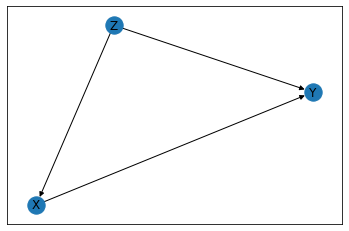

In [5]:
#create a graph representation
observational_scm_graph = nx.DiGraph()

#add directed nodes
observational_scm_graph.add_edge('Z', 'Y')
observational_scm_graph.add_edge('X', 'Y')
observational_scm_graph.add_edge('Z', 'X')

nx.draw_networkx(observational_scm_graph)
plt.show()


## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [6]:
# goede posts hierover:
# https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/ && https://www.inference.vc/untitled/

def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    """This function is used to create the data from the interventional distribution do(X=xi)."""

    # the creation of z remains unchanged
    z = f_Z(num_samples)
    
    # as we have intervened on x, we do not call the function f_X anymore, as we removed all incoming edges towards said node. Therefore will use the given x and not the random sample calculated using the variable z.
    #interventional_x = x

    # we create y a bit differently, as we now give the intervened x.
    y = f_Y(z, x, num_samples)
    return (x, y, z)


We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [7]:
num_samples_exp = 200 

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

In [8]:
x_exp_reshaped = x_exp.reshape((-1,1))

#predict response
experimental_predicted_y_values = model.predict(x_exp_reshaped)

Text(0, 0.5, 'Output')

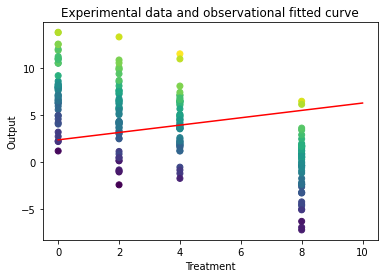

In [9]:
# plot the scatter plot on the experimental data including the curve fitted on observational data
plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(neatly_ordered_x_values, y_values_curve, 'r')
plt.title('Experimental data and observational fitted curve')
plt.xlabel('Treatment')
plt.ylabel('Outcome')

**Task (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [10]:
def ManualRMSE(y_true, y_pred):
    """
    A function to manually calculate the RMSE, as large variation was found when using mean_squared_error function from Sklearn.
    """
    MSE = np.square(np.subtract(y_true.reshape((-1,1)),y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

# Use the mean_squared_error function with the squared parameter set to false to get the RMSE of the difference between the observational y and predicted y using the observational data
print("RMSE on Observational Dataset")
rms_obs = mean_squared_error(y.reshape(-1,1), predicted_observational_y_values, squared=False)
print(f"RMSE between the observational y and the prediction of the observational data: {rms_obs}    \nManual calculated RMSE between the observational y and the prediction of the observational data  {ManualRMSE(y, predicted_observational_y_values)} \n\n")

# Use the mean_squared_error function with the squared parameter set to false to get the RMSE of the difference between the experimental y and predicted y using the experimental data
print("RMSE on Experimental Dataset")
rms_exp = mean_squared_error(y_exp.reshape(-1,1), experimental_predicted_y_values, squared=False)
print(f"RMSE between y and prediction of experimental data: {rms_exp} \nManual calculated RMSE between the experimental y and the prediction of the observational data  {ManualRMSE(y_exp, experimental_predicted_y_values)}")


RMSE on Observational Dataset
RMSE between the observational y and the prediction of the observational data: 1.9364342426729761    
Manual calculated RMSE between the observational y and the prediction of the observational data  2.241923358225922 


RMSE on Experimental Dataset
RMSE between y and prediction of experimental data: 5.068717267712354 
Manual calculated RMSE between the experimental y and the prediction of the observational data  4.378899546687436


# Question 2 

You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? In order for your fitted curve to also give good predictions on the experimental data, what conditional distribution would we need to stay the same between the two distributions?

# Answer Q2

As we conduct an intervention on $X$, we need to relate back to the formulas to identify which factors remain the same. Assuming that this is a perfect intervention, and looking at the formulas set above, we see that the structural equations for variables $x$ and $y$ do not change. We know from the formulas that in the original SCM variable $z$ was a parent of variable $x$ and $y$, and $x$ was a parent of $y$. Due to the intervention on $X$ this SCM graph is altered, as we remove all incoming edges from the node corresponding with variable $x$. After alteration, we are left with a collider (where variable $y$ is the collider). Using the assumption of perfect intervention, we know the product decomposition of the unchanged variables remain unchanged. Applying this to our altered SCM, we see that the following factor remains unchanged:

$$P_{m}(Z=z) = P(Z=z)$$


Furthermore, in order for the fitted curve to give good predictions on the experimental data, we need to make sure that the conditional probability $P(Y | Z, X)$ remains the same, as otherwise it would indicate that the process with which $Y$ responds to $X$ and $Z$, $Y= f(X,Z, uY)$ is altered and then we would be dealing with not only the intervention, but other acting factors, which could influence the prediction process. Therefore, we need to keep the following the same:
$$P_{m}(Y=y | Z=z, X=x) = P(Y=y | Z=z, X=x)$$


Using the former knowledge in combination with the knowledge that $X$ and $Z$ are independent through the triggering of the d-seperation rule (as we do not condition on the collider) we can calculating the adjustment formula, after which we are left with the following: 
 
$$P(Y=y | do(X=x)) = \sum_{z} P(Y=y | X=x, Z=z)P(Z=z) $$







# Question 3 D-seperation

The remaining questions use some concepts that we will see in the lectures of week 6 (d-separation and inverse probability weighing).

**Question (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

# Answer Q3

Due the intervention on $X$ resulting in $do(X=x_i)$, the Structural Causal Model changes. As stated before, we saw that the variable $y$ is a child of variables $x$ and $z$, where the variable $x$ is a child of variable $z$. This creates a triangle graph, with two outgoing edges (and none incoming) from variable $z$, one incoming and one outgoing edge from variable $x$ and two incoming edges to variable $y$. In the intervened model, we intervene on variable $x$, which means we remove all incoming edges to that variable. The adapted graph formed from the experimental distribution thus changes from a triangle to two parents pointing to one child, creating a collider. We know from *Rule 3* that in a case of a $X$ and $Z$ passing through a collider ($Y$), then $X$ and $Z$ are marginally independent, but could be dependent given $Y$ or any decendents of $Y$.

We know that we only have three variables and that the collider $Y$ does not have any decendants itself. We also know the edges in the graph as stated above. From this we can conclude that we are dealing with a simple path d-seperation. Following the definition of d-seperation, two variables $A$ and $B$ are d-seperated given a (set of) variable(s) $C$ if conditioning on $C$ **blocks every simple path** between $A$ and $B$. We also know that a collider blocks a path *if and only if* the collider is not conditioned on, and none of its descendants are. 

Translating the above to our context, we do not condition on variable $Y$ (the collider) and variable $Y$ has no descendants. As $Y$ is not part of the set $Z$ and we are thus not conditioning on the collider, we are blocking the simple path between $X$ and $Z$. As this is the only path between the variables, we can say that $X$ and $Z$ are d-seperated. Following this, we can combine the knowledge of conditional independence and d-seperation, letting us know that $X$ and $Z$ are conditionally independent given $Y$. This might seem suprising, as we often see that $X$ and $Z$ would be likely dependent given $Z$ in the case of colliders. However, this is only the case with open paths (i.e. non d-seperated cases). As this case fits the d-seperation rule, this dependence changes to a conditional independent variant.

The altered SCM is shown below. Furthermore, the scatter plot also highlights the independence between $X$ and $Z$. On visual inspection, there is no relationship (dependency) between $X$ and $Z$, since when the values of $X$ (treatment) changes, there is no systematic change in the values of $Z$ and vice versa.

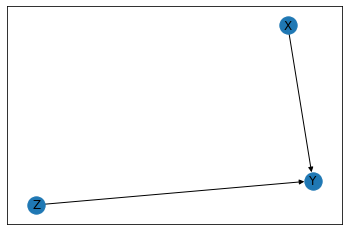

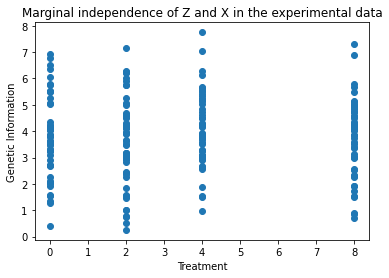

In [11]:
#make the graph representation of the experimental data to show independence
experimental_scm_graph = nx.DiGraph()
#add directed nodes
experimental_scm_graph.add_edge('Z', 'Y')
experimental_scm_graph.add_edge('X', 'Y')

nx.draw_networkx(experimental_scm_graph)
plt.show()

#make the scatter plot of the experimental data to show independence
plt.scatter(x_exp, z_exp)
plt.title('Marginal independence of Z and X in the experimental data')
plt.xlabel('Treatment')
plt.ylabel('Genetic Information')
plt.show()



# Task 4 IPW

**Task (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract estimates for $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [12]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

#fit the logistic reg model using observational data to predict X using Z as a feature
reshaped_z = np.array(z).reshape((-1,1))

reg_logistic.fit(reshaped_z, reshaped_x) 

## list of lists, where each row corresponds with a z value and each column of said row (the innerlist) the probability of data point z belonging to one of 6 specific class treatment (x) classes
all_probs = reg_logistic.predict_proba(reshaped_z)

c:\Users\Simon\Desktop\Code\Advanced ML\test_venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Get the X value of each data point, get the corresponding probability, inverse that weight, and then give that along

In [17]:
propensity_scores_per_data_point = []

for index, dosage in enumerate(x):
    # get the index of the propensity corresponding with the treatment dosage
    probability_index = dosage // 2
    #get the propensity score from the list of probabilities
    dosage_prob = all_probs[index][probability_index]
    # Save the propensity scores of the corresponding treatment dosage in a list
    propensity_scores_per_data_point.append(dosage_prob)

Inverse_probability_weights = []
# 1000 z values
for index, propensity_score in enumerate(propensity_scores_per_data_point):
    ipw_treatment =  1/propensity_score
    Inverse_probability_weights.append(ipw_treatment)    
    

**Task (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

In [18]:
Inverse_probability_weights_arr = np.array(Inverse_probability_weights)

model_with_IPW = linear_model.LinearRegression().fit(reshaped_x, y, sample_weight = Inverse_probability_weights_arr)

IPW_exp_y_values = model_with_IPW.predict(x_exp_reshaped)

Text(0, 0.5, 'Outcome')

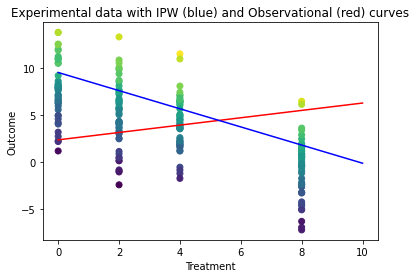

In [19]:
#applying np.linspace
IPW_neatly_ordered_x_values = np.linspace(0, 10, num=1000).reshape((-1,1))
# calculate the linear regression line with the IPW weight included model
y_curve_IPW = model_with_IPW.predict(IPW_neatly_ordered_x_values)


plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(neatly_ordered_x_values, y_values_curve, 'r')
plt.plot(IPW_neatly_ordered_x_values, y_curve_IPW, 'b')
plt.title('Experimental data with IPW (blue) and Observational (red) curves')
plt.xlabel('Treatment')
plt.ylabel('Outcome')

**Task (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [16]:
IPW_exp = model_with_IPW.predict(x_exp.reshape(-1,1))



# Use the mean_squared_error function with the squared parameter set to false to get the RMSE of the difference between the experimental y and predicted y using the experimental data and IPW
rms_exp_IPW = mean_squared_error(y_exp.reshape(-1,1), IPW_exp_y_values, squared=False)
print("Results of IPW weighted RMSE in the experimental data")
print(f"RMSE between y and prediction of experimental data using Sklearn mean_squared_error: {rms_exp_IPW} \nManual calculated RMSE between the experimental y and the prediction of y in the experimental data with IPW: {ManualRMSE(y_exp, IPW_exp_y_values)} \n\n")


Without_IPW_RMSE_manual = ManualRMSE(y_exp, experimental_predicted_y_values)
With_IPW_RMSE_Manual = ManualRMSE(y_exp, IPW_exp_y_values)

print("Differences between the RMSE of the IPW-less experimental prediction and the IPW included experimental prediction")
print(f"Comparing the two RMSE calculated with Sklearn package: {(abs(rms_exp - rms_exp_IPW) / rms_exp ) *100}  \nComparing the two RMSE calculated manually {(abs(Without_IPW_RMSE_manual - With_IPW_RMSE_Manual ) / Without_IPW_RMSE_manual ) *100}")

Results of IPW weighted RMSE in the experimental data
RMSE between y and prediction of experimental data using Sklearn mean_squared_error: 3.7319165655919835 
Manual calculated RMSE between the experimental y and the prediction of y in the experimental data with IPW: 5.476686428331866 


Differences between the RMSE of the IPW-less experimental prediction and the IPW included experimental prediction
Comparing the two RMSE calculated with Sklearn package: 26.373550378036846  
Comparing the two RMSE calculated manually 25.06992612961142


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).